In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

def safe_array_divide(numerator, denominator):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(numerator, denominator)
        ratio = np.nan_to_num(ratio, nan=0, posinf=0, neginf=0)
    return ratio


In [2]:
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']
filename = './MLP_classifier.model'
scaler_filename = './scaler.pkl'
sample_all_jets_path = '../../../samples/sample_allpt_all_jets.pkl'

sample_path = '../../../samples/sample_allpt_all_jets.pkl'
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
layers = (10, 5, 4)


In [3]:
sample = pd.read_pickle(sample_path)

In [4]:
print(sample.head())

       jet_pt   jet_eta  jet_nTracks  jet_trackWidth  jet_trackC1  \
0  766.747925  1.298662          2.0        0.318292     0.215923   
0  680.507996  0.447689         24.0        0.064352     0.208339   
1  619.839111  0.588775         34.0        0.115656     0.298206   
2  721.692932 -0.716669         12.0        0.049718     0.220595   
3  697.332947 -1.042831         22.0        0.091199     0.278667   

   jet_trackBDT  jet_PartonTruthLabelID  equal_weight  event_weight  \
0     -0.192873                    21.0           1.0     17.609434   
0      0.066904                     2.0           1.0      0.331535   
1      0.232268                    21.0           1.0      0.331535   
2     -0.169604                     2.0           1.0      0.377624   
3      0.029374                    21.0           1.0      0.377624   

   flatpt_weight  is_forward  pt_idx  target  
0   2.703190e-05         1.0       1     1.0  
0   2.858433e-07         0.0       1     0.0  
1   1.655248e-07 

In [5]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [6]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [7]:
with open(scaler_filename, 'rb') as f:
    scaler = pickle.load(f)

with open(filename, 'rb') as f:
    clf = pickle.load(f)

# pt bins

## MLP distributions

In [8]:
features = [*sample.columns[:6]] + ['new_MLPprob'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(0.0, 1.0, 51),
}


In [9]:
y_sample = clf.predict_proba(scaler.transform(sample[training_vars]))[:,1]
sample['new_MLPprob'] = y_sample

In [10]:
sample.to_pickle('pred_sample.pkl')

In [11]:
sample = pd.read_pickle('pred_sample.pkl')

In [12]:
sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target,new_MLPprob
0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,1.0,17.609434,2.703190e-05,1.0,1,1.0,0.024667
0,680.507996,0.447689,24.0,0.064352,0.208339,0.066904,2.0,1.0,0.331535,2.858433e-07,0.0,1,0.0,0.467134
1,619.839111,0.588775,34.0,0.115656,0.298206,0.232268,21.0,1.0,0.331535,1.655248e-07,1.0,1,1.0,0.836097
2,721.692932,-0.716669,12.0,0.049718,0.220595,-0.169604,2.0,1.0,0.377624,3.935379e-07,0.0,1,0.0,0.167972
3,697.332947,-1.042831,22.0,0.091199,0.278667,0.029374,21.0,1.0,0.377624,3.255802e-07,1.0,1,1.0,0.549226


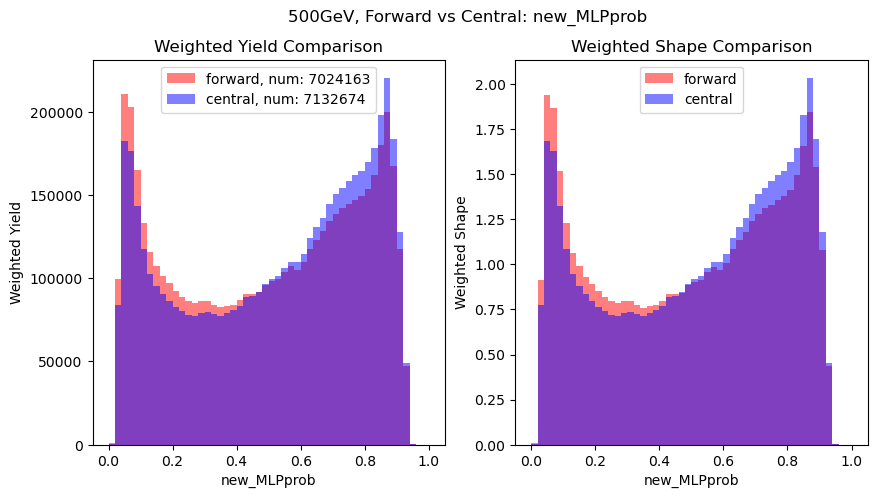

In [13]:
# for pt_idx, pt in enumerate(label_pt_bin[-2:-1]):

for pt_idx, pt in enumerate(label_pt_bin[0:1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx] 

    sample_forward = sample_pt[sample_pt['is_forward']==1]
    sample_central = sample_pt[sample_pt['is_forward']==0]

    for feature_name in features[-1:]:
        custom_bins = HistBins[feature_name]
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
        ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
        ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
        ax0.legend()
        ax0.set_xlabel(feature_name)
        ax0.set_ylabel(f"Weighted Yield")
        ax0.set_title(f"Weighted Yield Comparison")
        if feature_name == 'jet_pt':
            ax0.set_yscale('log')

        ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
        ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
        ax1.legend()
        ax1.set_xlabel(feature_name)
        ax1.set_ylabel(f"Weighted Shape")
        ax1.set_title(f"Weighted Shape Comparison")
        if feature_name == 'jet_pt':
            ax1.set_yscale('log')
        fig.suptitle(f"{pt}GeV, Forward vs Central: {feature_name}")
        plt.plot()
    

## test extraction

### No Reweighting

In [14]:
sample['quark_reweighting_weights'] = sample['event_weight'].copy()
sample['gluon_reweighting_weights'] = sample['event_weight'].copy()
newbdt_bins = np.linspace(0, 1, 101)
feature = 'new_MLPprob'

reweighted_sample = []
# for pt_idx, pt in enumerate(label_pt_bin[:-1]):
# for pt_idx, pt in enumerate(label_pt_bin[pt_idx:pt_idx+1]):
for pt_idx, pt in enumerate(label_pt_bin[0:1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx]  
    _sample = sample_pt
    forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
    forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
    central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
    central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
    forward = _sample[(_sample['is_forward']==1)]
    central = _sample[(_sample['is_forward']==0)]
    quark = _sample[_sample['target']==0]
    gluon = _sample[_sample['target']==1]

    #### Forward vs Central 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward, _, _ = ax[0][0].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5)
    hist_central, _, _ = ax[0][0].hist(central[feature], bins = newbdt_bins, weights = central['event_weight'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['event_weight'])}", 
                                       color='blue', alpha = 0.5)
    ax[0][0].legend()
    ax[0][0].set_xlabel(feature)
    ax[0][0].set_ylabel(f"Weighted Yield")
    ax[0][0].set_title(f"Weighted Yield Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][0].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][0].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('MLP prob')


    hist_forward, _, _ = ax[0][1].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5, density=True)
    hist_central, _, _ = ax[0][1].hist(central[feature], bins = newbdt_bins, weights = central['event_weight'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['event_weight'])}", 
                                       color='blue', alpha = 0.5, density=True)    
    ax[0][1].legend()
    ax[0][1].set_xlabel(feature)
    ax[0][1].set_ylabel(f"Weighted Shape")
    ax[0][1].set_title(f"Weighted Shape Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][1].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][1].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('MLP prob')

    fig.suptitle(f"Forward vs Central: {feature}, no reweighting")

    #### Quark, Gluon, Forward vs Central     
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward_quark, _, _ = ax[0][0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    hist_central_quark, _, _ = ax[0][0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0][0].legend()
    ax[0][0].set_ylabel('MLP prob distribution')
    ax[0][0].set_title('quark: Forward vs. Central, no reweighting')

    newMLP_quark_factor = safe_array_divide(numerator=hist_forward_quark, denominator=hist_central_quark) 
    ax[1][0].stairs(values=newMLP_quark_factor, edges=newbdt_bins, label=f'quark factor')
    ax[1][0].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('quark factor')
    ax[1][0].set_xlabel('MLP prob')



    new_clf_idx = pd.cut(_sample[feature], bins=newbdt_bins, right=False, labels=False) 
    for i, score in enumerate(newbdt_bins[:-1]):
        mod_idx = np.where(new_clf_idx == i)[0]
        _sample.iloc[mod_idx, _sample.columns.get_loc('quark_reweighting_weights')] *= newMLP_quark_factor[i]


    hist_forward_gluon, _, _ = ax[0][1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    hist_central_gluon, _, _ = ax[0][1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[0][1].set_title('gluon: Forward vs. Central, no reweighting')
    ax[0][1].legend()
    ax[0][1].set_ylabel('MLP prob distribution')
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}, no reweighting")

    newMLP_gluon_factor = safe_array_divide(numerator=hist_forward_gluon, denominator=hist_central_gluon) 
    ax[1][1].stairs(values=newMLP_gluon_factor, edges=newbdt_bins, label=f'gluon factor')
    ax[1][1].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('gluon factor')
    ax[1][1].set_xlabel('MLP prob')


    reweighted_sample.append(_sample)
    
    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)

    # Do a simple extraction test
    # MC closure 
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)

    n_forward_quark2 = np.sum(forward_quark['event_weight'])
    n_central_quark2 = np.sum(central_quark['event_weight'])
    n_forward2 = np.sum(forward['event_weight'])
    n_central2 = np.sum(central['event_weight'])

    frac_forward_quark2 = n_forward_quark2 / n_forward2
    frac_central_quark2 = n_central_quark2 / n_central2

    frac_forward_gluon2 = 1 - frac_forward_quark2
    frac_central_gluon2 = 1 - frac_central_quark2

    f2 = np.array([[frac_forward_quark2,  frac_forward_gluon2], [frac_central_quark2, frac_central_gluon2]])
    f2_inv = np.linalg.inv(f2)


    extract_p_Quark = f2_inv[0][0] * hist_forward + f2_inv[0][1]* hist_central 
    extract_p_Gluon = f2_inv[1][0] * hist_forward + f2_inv[1][1]* hist_central 

#     n_forward_quark = len(forward_quark)
#     n_central_quark = len(central_quark)
#     n_forward = len(forward)
#     n_central = len(central)

#     frac_forward_quark = n_forward_quark / n_forward
#     frac_central_quark = n_central_quark / n_central

#     frac_forward_gluon = 1 - frac_forward_quark
#     frac_central_gluon = 1 - frac_central_quark

#     f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
#     f_inv = np.linalg.inv(f)

#     extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
#     extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 
    #### Extraction plots 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_truth_quark, _, _ = ax[0][0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0][0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0][0].legend()
    ax[0][0].set_title('quark: Truth vs. Extracted MC, after reweighting')

    extraction_quark_ratio = safe_array_divide(numerator=extract_p_Quark, denominator=hist_truth_quark) 
    ax[1][0].stairs(values=extraction_quark_ratio, edges=newbdt_bins, label=f'quark extracted/truth')
    ax[1][0].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('MLP prob')

    hist_truth_gluon, _, _ = ax[0][1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
                                label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[0][1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[0][1].legend()
    ax[0][1].set_title('gluon: Truth vs. Extracted MC, after reweighting')

    extraction_gluon_ratio = safe_array_divide(numerator=extract_p_Gluon, denominator=hist_truth_gluon) 
    ax[1][1].stairs(values=extraction_gluon_ratio, edges=newbdt_bins, label=f'gluon extracted/truth')
    ax[1][1].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('MLP prob')

    fig.suptitle(f"{pt} GeV, Extraction, {feature}, no reweighting")

reweighted_sample = pd.concat(reweighted_sample)

: 

: 

### After reweighting

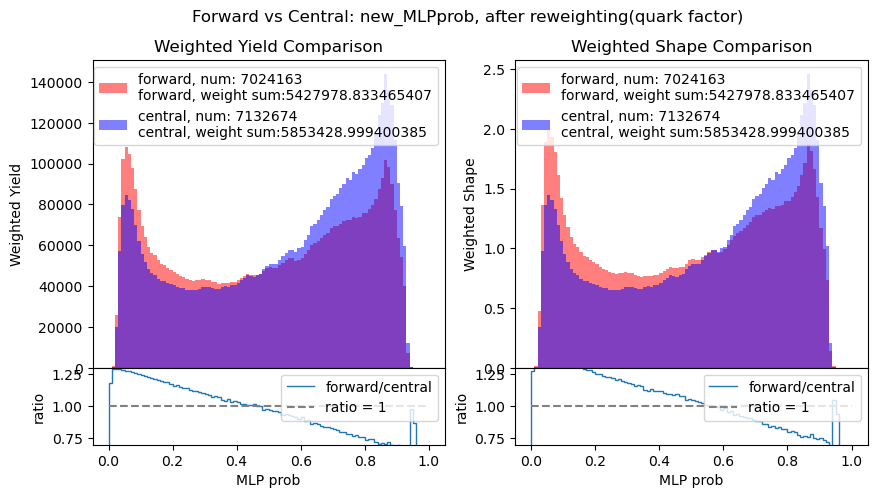

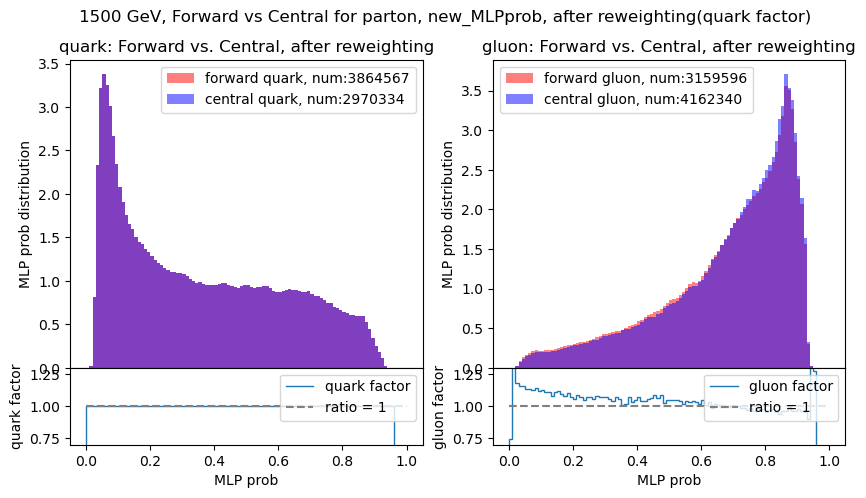

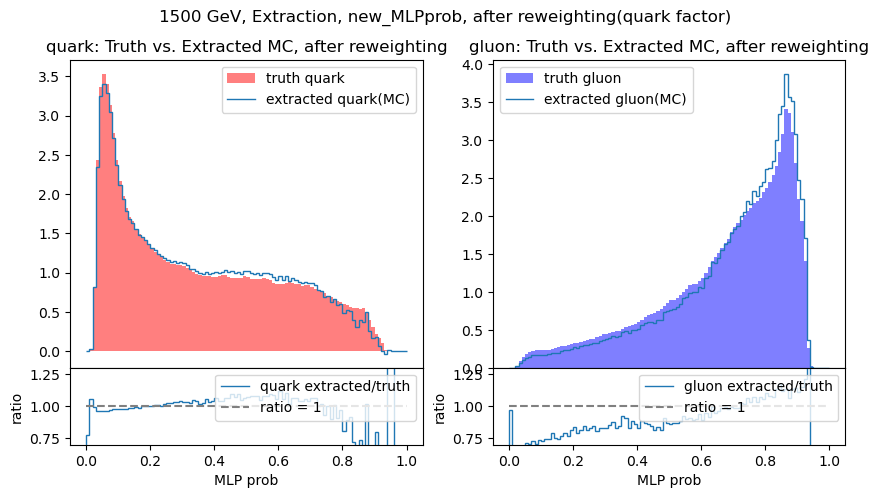

In [ ]:
# for pt_idx, pt in enumerate(label_pt_bin[:-1]):
# for pt_idx, pt in enumerate(label_pt_bin[pt_idx:pt_idx+1]):
for pt_idx, pt in enumerate(label_pt_bin[0:1]):
    sample_pt = reweighted_sample[reweighted_sample['pt_idx'] == pt_idx]  
    _sample = sample_pt
    forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
    forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
    central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
    central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
    forward = _sample[(_sample['is_forward']==1)]
    central = _sample[(_sample['is_forward']==0)]
    quark = _sample[_sample['target']==0]
    gluon = _sample[_sample['target']==1]

    #### Forward vs Central 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward, _, _ = ax[0][0].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5)
    hist_central, _, _ = ax[0][0].hist(central[feature], bins = newbdt_bins, weights = central['quark_reweighting_weights'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['quark_reweighting_weights'])}", 
                                       color='blue', alpha = 0.5)
    ax[0][0].legend()
    ax[0][0].set_xlabel(feature)
    ax[0][0].set_ylabel(f"Weighted Yield")
    ax[0][0].set_title(f"Weighted Yield Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][0].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][0].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('MLP prob')


    hist_forward, _, _ = ax[0][1].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5, density=True)
    hist_central, _, _ = ax[0][1].hist(central[feature], bins = newbdt_bins, weights = central['quark_reweighting_weights'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['quark_reweighting_weights'])}", 
                                       color='blue', alpha = 0.5, density=True)    
    ax[0][1].legend()
    ax[0][1].set_xlabel(feature)
    ax[0][1].set_ylabel(f"Weighted Shape")
    ax[0][1].set_title(f"Weighted Shape Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][1].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][1].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('MLP prob')

    fig.suptitle(f"Forward vs Central: {feature}, after reweighting(quark factor)")


    #### Quark, Gluon, Forward vs Central     
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward_quark, _, _ = ax[0][0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    hist_central_quark, _, _ = ax[0][0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['quark_reweighting_weights'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0][0].legend()
    ax[0][0].set_ylabel('MLP prob distribution')
    ax[0][0].set_title('quark: Forward vs. Central, after reweighting')


    newMLP_quark_factor = safe_array_divide(numerator=hist_forward_quark, denominator=hist_central_quark) 
    ax[1][0].stairs(values=newMLP_quark_factor, edges=newbdt_bins, label=f'quark factor')
    ax[1][0].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('quark factor')
    ax[1][0].set_xlabel('MLP prob')


    hist_forward_gluon, _, _ = ax[0][1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    hist_central_gluon, _, _ = ax[0][1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['quark_reweighting_weights'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[0][1].set_title('gluon: Forward vs. Central, after reweighting')
    ax[0][1].legend()
    ax[0][1].set_ylabel('MLP prob distribution')
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}, after reweighting(quark factor)")

    newMLP_gluon_factor = safe_array_divide(numerator=hist_forward_gluon, denominator=hist_central_gluon) 
    ax[1][1].stairs(values=newMLP_gluon_factor, edges=newbdt_bins, label=f'gluon factor')
    ax[1][1].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('gluon factor')
    ax[1][1].set_xlabel('MLP prob')

    #### Apply quark factor 
    new_clf_idx = pd.cut(_sample[feature], bins=newbdt_bins, right=False, labels=False) 
    for i, score in enumerate(newbdt_bins[:-1]):
        mod_idx = np.where(new_clf_idx == i)[0]
        _sample.iloc[mod_idx, _sample.columns.get_loc('quark_reweighting_weights')] *= newMLP_quark_factor[i]

    # Do a simple extraction test
    # MC closure 
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['quark_reweighting_weights'], density = True)

    n_forward_quark2 = np.sum(forward_quark['event_weight'])
    n_central_quark2 = np.sum(central_quark['quark_reweighting_weights'])
    n_forward2 = np.sum(forward['event_weight'])
    n_central2 = np.sum(central['quark_reweighting_weights'])

    frac_forward_quark2 = n_forward_quark2 / n_forward2
    frac_central_quark2 = n_central_quark2 / n_central2

    frac_forward_gluon2 = 1 - frac_forward_quark2
    frac_central_gluon2 = 1 - frac_central_quark2

    f2 = np.array([[frac_forward_quark2,  frac_forward_gluon2], [frac_central_quark2, frac_central_gluon2]])
    f2_inv = np.linalg.inv(f2)

    extract_p_Quark = f2_inv[0][0] * hist_forward + f2_inv[0][1]* hist_central 
    extract_p_Gluon = f2_inv[1][0] * hist_forward + f2_inv[1][1]* hist_central 

#     n_forward_quark = len(forward_quark)
#     n_central_quark = len(central_quark)
#     n_forward = len(forward)
#     n_central = len(central)

#     frac_forward_quark = n_forward_quark / n_forward
#     frac_central_quark = n_central_quark / n_central

#     frac_forward_gluon = 1 - frac_forward_quark
#     frac_central_gluon = 1 - frac_central_quark

#     f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
#     f_inv = np.linalg.inv(f)

#     extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
#     extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

    #### Extraction plots 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_truth_quark, _, _ = ax[0][0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0][0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0][0].legend()
    ax[0][0].set_title('quark: Truth vs. Extracted MC, after reweighting')

    extraction_quark_ratio = safe_array_divide(numerator=extract_p_Quark, denominator=hist_truth_quark) 
    ax[1][0].stairs(values=extraction_quark_ratio, edges=newbdt_bins, label=f'quark extracted/truth')
    ax[1][0].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('MLP prob')

    hist_truth_gluon, _, _ = ax[0][1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
                                label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[0][1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[0][1].legend()
    ax[0][1].set_title('gluon: Truth vs. Extracted MC, after reweighting')

    extraction_gluon_ratio = safe_array_divide(numerator=extract_p_Gluon, denominator=hist_truth_gluon) 
    ax[1][1].stairs(values=extraction_gluon_ratio, edges=newbdt_bins, label=f'gluon extracted/truth')
    ax[1][1].hlines(y = 1, xmin = 0, xmax = 1, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('MLP prob')


    fig.suptitle(f"{pt} GeV, Extraction, {feature}, after reweighting(quark factor)")